# Modeling multiple systems with system losses

This tutorial provides an outline of techniques to model single inverter systems with multiple strings. 

A number of complexities are included:

- Converting a CSV to a dictionary of system losses
- Modeling multiple systems at a time
- Modeling inverters with temperature derating applied to maximum power output


In [33]:
# built-in imports
import sys
import datetime
import os.path
import inspect

# add-on imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_color_codes()
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

import numpy as np

# pvlib imports
from pvlib.atmosphere import get_relative_airmass
from pvlib.location import Location
from pvlib.solarposition import get_solarposition
from pvlib import clearsky
from pvlib import tmy
from pvlib.irradiance import get_extra_radiation
from pvlib import clearsky
from pvlib.irradiance import get_ground_diffuse
from pvlib.irradiance import get_sky_diffuse
from pvlib.pvsystem import retrieve_sam

import logging
logging.getLogger('pvlib').setLevel(logging.WARNING) # WARNING to avoid clearsky output, INFO or DEBUG for more



# Import site configuration data

The dictionary holding the configuration data below is a beginning point to discuss a structure for system losses. It will likely be improved upon and standardized in the future. 

In [34]:
data = pd.read_csv('Narnaul_site/data/solar_data/inverter_data_final.csv')
site_config = pd.read_csv('site_config.csv')
# def remove_seconds(x):
#     x = x.split(':')
#     y = x[0]+':'+x[1]+':'+'00'
#     return y
# data['Timestamp'] = data.Timestamp.apply(lambda x: remove_seconds(x))
# data.to_csv('inverter_data_final.csv', index=False)
# data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')

In [47]:
moddb = retrieve_sam(name='CECMod')
invdb = retrieve_sam(name='CECInverter')
sandb = retrieve_sam(name='Sandiamod')

In [48]:
for samp in moddb:
    if 'Vikram' in samp:
        print(samp)

Vikram_Solar_ELDORA_270
Vikram_Solar_Eldora_VSP_60_240_03
Vikram_Solar_Eldora_VSP_60_245_03
Vikram_Solar_Eldora_VSP_60_250_03
Vikram_Solar_Eldora_VSP_60_255_03
Vikram_Solar_Eldora_VSP_60_260_03
Vikram_Solar_Eldora_VSP_60_265_03
Vikram_Solar_Eldora_VSP_60_270_03
Vikram_Solar_Eldora_VSP_72_295_03
Vikram_Solar_Eldora_VSP_72_300_03
Vikram_Solar_Eldora_VSP_72_305_03
Vikram_Solar_Eldora_VSP_72_310_03
Vikram_Solar_Eldora_VSP_72_315_03
Vikram_Solar_Eldora_VSP_72_320_03
Vikram_Solar_Eldora_VSP_72_325_03
Vikram_Solar_Eldora_VSPB_60_245_03
Vikram_Solar_Eldora_VSPB_60_250_03
Vikram_Solar_Eldora_VSPB_60_255_03
Vikram_Solar_Eldora_VSPB_60_260_03
Vikram_Solar_Eldora_VSPB_60_265_03


In [35]:
location = Location(site_config.Latitude[0],site_config.Longitude[0],
							site_config.Timezone[0],site_config.Elev[0], 'Narnaul')
# times = pd.date_range(data.Timestamp[0], data.Timestamp[data.shape[0]-1], freq='15min',tz='Asia/Kolkata')

times = pd.to_datetime([time for time in data['Timestamp']])

In [36]:
solar_position_df = location.get_solarposition(times,method='pyephem')

In [37]:
solar_position_df

,apparent_elevation,apparent_azimuth,elevation,azimuth,apparent_zenith,zenith
2017-12-18 08:30:00,33.436781,206.941673,33.413340,206.941673,56.563219,56.586660
2017-12-18 08:35:00,32.927212,208.168743,32.903309,208.168743,57.072788,57.096691
2017-12-18 08:40:00,32.397032,209.376157,32.372638,209.376157,57.602968,57.627362
2017-12-18 08:50:00,31.277116,211.731233,31.251636,211.731233,58.722884,58.748364
2017-12-18 09:05:00,29.456892,215.113270,29.429485,215.113270,60.543108,60.570515
2017-12-18 09:20:00,27.481637,218.315536,27.451879,218.315536,62.518363,62.548121
2017-12-18 09:25:00,26.791297,219.343643,26.760644,219.343643,63.208703,63.239356
2017-12-18 09:30:00,26.085872,220.352448,26.054255,220.352448,63.914128,63.945745
2017-12-18 09:35:00,25.365866,221.342211,25.333218,221.342211,64.634134,64.666782
2017-12-18 09:40:00,24.631781,222.313191,24.598021,222.313191,65.368219,65.401979


In [19]:
relairm = get_relative_airmass(solar_position_df['apparent_zenith'], 'pickering2002')

In [40]:
extrat = get_extra_radiation(times,method='spencer')
# extrat = get_extra_radiation(times,method='spencer')
extrat.head()

2017-12-18 08:30:00    1412.052742
2017-12-18 08:35:00    1412.052742
2017-12-18 08:40:00    1412.052742
2017-12-18 08:50:00    1412.052742
2017-12-18 09:05:00    1412.052742
dtype: float64

In [34]:
clear_sky_df = location.get_clearsky(times, model='ineichen')
clear_sky_df.head()

,ghi,dni,dhi
2017-12-18 08:30:00,544.590159,841.465604,80.916630
2017-12-18 08:35:00,535.528849,837.630425,80.203210
2017-12-18 08:40:00,526.051918,833.523136,79.451948
2017-12-18 08:50:00,505.874397,824.433477,77.834035
2017-12-18 09:05:00,472.644784,808.350621,75.109939


In [43]:
print(clear_sky_df.shape, extrat.shape, relairm.shape)

(16498, 3) (16498,) (16498,)


In [23]:
ground_diff_df = get_ground_diffuse(40,clear_sky_df['ghi'],0.25,'sand')

In [44]:
surf_tilt = 40
surf_az = 0
sky_diff_df = get_sky_diffuse(surf_tilt, surf_az,solar_position_df['zenith'], solar_position_df['azimuth'],
                clear_sky_df['dni'],clear_sky_df['ghi'],dhi=clear_sky_df['dhi'],dni_extra=extrat,airmass=relairm,model='perez')

/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/irradiance.py:1150: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/irradiance.py:1153: RuntimeWarning: invalid value encountered in maximum
  F2 = np.maximum(F2, 0)
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/irradiance.py:1167: RuntimeWarning: invalid value encountered in maximum
  sky_diffuse = np.maximum(dhi * (term1 + term2 + term3), 0)


In [ ]:
solar_position_df

In [ ]:
# Replaces all punctuation in equipment (module/inverter) names with underscores to match Sandia databases
def clean_punc(equip):
    equip = equip.replace(' ', '_').replace('-', '_').replace('.', '_').replace('(', '_').replace('/', '_')
    equip = equip.replace(')', '_').replace('[', '_').replace(']', '_').replace(':', '_').replace('+', '_')
    equip = equip.replace('"', '_')
    return equip


# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
# datapath = os.path.join(pvlib_abspath, 'data', 'site_config.csv')

# Import site config data, skipping any row starting with #
# In this file, each line represents a site with one inverter
site_config = pd.read_csv('site_config.csv')

# Solar position code needs a Location object
m = pvlib.location.Location(np.array(site_config[site_config['Parameter'] == 'Latitude'].Value)[0], 
                            np.array(site_config[site_config['Parameter'] == 'Longitude'].Value)[0], 
                            np.array(site_config[site_config['Parameter'] == 'Timezone'].Value)[0], 
                            float(site_config[site_config['Parameter'] == 'Elev (meters)'].Value), 
                            np.array(site_config[site_config['Parameter'] == 'Plant Name'].Value)[0]) ## One common name for site

# Systemdef needs a dict instead of a Location object
s = pvlib.pvsystem.systemdef({'latitude': np.array(site_config[site_config['Parameter'] == 'Latitude'].Value)[0],
                              'longitude': np.array(site_config[site_config['Parameter'] == 'Longitude'].Value)[0],
                              'altitude': float(site_config[site_config['Parameter'] == 'Elev (meters)'].Value),
                              'TZ': np.array(site_config[site_config['Parameter'] == 'Timezone'].Value)[0],
                              'Name': np.array(site_config[site_config['Parameter'] == 'Plant Name'].Value)[0]}, ## Specific name for subarray
                             int(np.array(site_config[site_config['Parameter'] =='surface_tilt'].Value)[0]),
                             int(np.array(site_config[site_config['Parameter'] == 'surface_azimuth'].Value)[0]),
                             float(np.array(site_config[site_config['Parameter'] == 'albedo'].Value)[0]),
                             int(np.array(site_config[site_config['Parameter'] == 'series_modules'].Value)[0]),
                             float(np.array(site_config[site_config['Parameter'] == 'parallel_modules'].Value)[0]))
# Other equipment information that isn't stored in systemdef
e = {'module_name': clean_punc(np.array(site_config[site_config['Parameter'] == 'module_name'].Value)[0]), 
     'module_count': int(np.array(site_config[site_config['Parameter'] == 'module_count'].Value)[0]),
     'module_wattage': float(np.array(site_config[site_config['Parameter'] == 'module_wattage'].Value)[0]),
     'inverter_name': clean_punc(np.array(site_config[site_config['Parameter'] == 'inverter_name'].Value)[0]), 
     'inverter_count': int(np.array(site_config[site_config['Parameter'] == 'inverter_count'].Value)[0]), 
     'inverter_pmax': int(np.array(site_config[site_config['Parameter'] == 'inv_pmax'].Value)[0]),
     'inverter_pnom': int(np.array(site_config[site_config['Parameter'] == 'inv_pnom'].Value)[0]), # in kW in config file
     'inverter_pmax_default': int(np.array(site_config[site_config['Parameter'] == 'inv_pmax_default'].Value)[0]), # in kW in config file
     'inverter_pmax_temp': int(np.array(site_config[site_config['Parameter'] == 'inv_pmax_temp'].Value)[0]),
     'inverter_pnom_temp': int(np.array(site_config[site_config['Parameter'] == 'inv_pnom_temp'].Value)[0]),
     'row_pitch': float(np.array(site_config[site_config['Parameter'] == 'pitch'].Value)[0])}
# # System Losses
# q = {'soiling': float(site_config[site_config['Plant Name'] == n].iloc[0]['Soiling']),
#      'dcohmic': float(site_config[site_config['Plant Name'] == n].iloc[0]['DCOhmic']),
#      'mqf': float(site_config[site_config['Plant Name'] == n].iloc[0]['MQF']),
#      'lid': float(site_config[site_config['Plant Name'] == n].iloc[0]['LID']),
#      'mismatch': float(site_config[site_config['Plant Name'] == n].iloc[0]['Mismatch']),
#      'acohmic': float(site_config[site_config['Plant Name'] == n].iloc[0]['ACOhmic']),
#      'mvload': float(site_config[site_config['Plant Name'] == n].iloc[0]['MVLoad']),
#     }
meta = [s,e]

# # Load Module and Inverter dbs
# ## Direct from Sandia, or can download locally and provide filename -- much faster
# moddb = pvlib.pvsystem.retrieve_sam(name='CECMod')
# invdb = pvlib.pvsystem.retrieve_sam(name='CECInverter')

# # Confirm sites loaded, and Lat/Long
# for n in site_names:
#     print(meta[n][1]['name'],": ",meta[n][1]['latitude'], meta[n][1]['longitude'])

# Define key system model method

This method takes system configuration information and applies it to the environmental data to create modeled power for each time sample. It can be used with standard TMY3 hour data, or finer grain environmental data, if available.

Note that the meta defined in this method is a subset of the meta defined in the overarching script.

In [ ]:
def subarray(meta, d, module_type, inverter_type, 
             inv_pmax, inv_pnom, inv_pmax_default, inv_pmax_temp, inv_pnom_temp,
             pitch, col, losses):
    df = d
    # Find Isc at STC for DC ohmic loss estimate
    IL,I0,Rs,Rsh,nNsVth=pvlib.pvsystem.calcparams_desoto(poa_global=1000,
                                                         temp_cell=25,
                                                         alpha_isc=.003,
                                                         module_parameters=module_type,
                                                         EgRef=1.121,
                                                         dEgdT= -0.0002677)
    DFOut = pvlib.pvsystem.singlediode(module_type, IL, I0, Rs, Rsh, nNsVth)
    stc_i_sc = DFOut['i_sc']
    # Calculate Isc for entire array by multiplying Isc by number of parallel modules (actually strings)
    # Used as basis to scale DC and AC ohmic losses
    stc_array_i_sc = stc_i_sc * meta['parallel_modules']

    # Calculate IAM
    df['IAMa'] = pvlib.pvsystem.ashraeiam(b = 0.05, aoi = df['AOI'])
    df['IAMa'].fillna(0, inplace=True)

    # Soiling
    df['Soiling'] = 1 - losses['soiling']

    # Calculate module IV params for POA and temps experienced
    IL,I0,Rs,Rsh,nNsVth=pvlib.pvsystem.calcparams_desoto(poa_global=df['poa_global'],
                                                         temp_cell=df['tcell'],
                                                         alpha_isc=.003,
                                                         module_parameters=module_type,
                                                         EgRef=1.121,
                                                         dEgdT= -0.0002677)
    DFOut = pvlib.pvsystem.singlediode(module_type, IL, I0, Rs, Rsh, nNsVth)
    df['sd_i_mp'] = DFOut['i_mp']
    df['sd_v_oc'] = DFOut['v_oc']
    df['sd_v_mp'] = DFOut['v_mp']
    df['sd_p_mp'] = DFOut['p_mp']
    df['sd_i_x'] = DFOut['i_x']
    df['sd_i_xx'] = DFOut['i_xx']


    # Module Quality
    df['MQF'] = 1 - losses['mqf']
    # LID
    df['LID'] = 1 - losses['lid']
    # Mismatch
    df['Mismatch'] = 1 - losses['mismatch']
    # DC kW
    df['sd_string_v_mp'] = meta['series_modules'] * df.sd_v_mp
    df['sd_array_i_mp'] = meta['parallel_modules'] * df.sd_i_mp
    # DC ohmic
    df['DCohmic'] = 1 - losses['dcohmic'] * pow(df.sd_array_i_mp / stc_array_i_sc, 2)
    df['sd_array_p_mp'] = df.sd_string_v_mp * df.sd_array_i_mp * df.DCohmic * df.MQF * df.LID * df.Mismatch
    df['sd_array_kp_mp'] = df.sd_array_p_mp / 1000

    # Temperature Derate of Inverter
    # Approximating warmer temps input to inverter
    df['Tinv'] = df['DryBulb'] + 4 
    ## Model doesn't include sharp drop limit over 50C
    # Calculate maximum clipping level based on temperature. Clip level is never lower than nominal inverter level (pmax).
    def clip_level(tamb):
        return min(inv_pmax,
                   inv_pmax_default - max(tamb - inv_pmax_temp,0) * (inv_pmax_default - inv_pnom) / (inv_pnom_temp - inv_pmax_temp))/1000

    df['ACPowerClipLevel'] = df['Tinv'].apply(clip_level)
    # AC kW
    df['ACPower'] = pvlib.pvsystem.snlinverter(v_dc = df.sd_string_v_mp,
                                               p_dc = df.sd_array_p_mp,
                                               inverter = inverter_type) / 1000
    # Clip any ACPower values that exceed temperature bounded maximum
    df['ACPowerClipped'] = pd.DataFrame([df['ACPower'], df['ACPowerClipLevel']]).min()

    # AC ohmic
    df['ACohmic'] = 1 - losses['acohmic'] * pow(df.sd_array_i_mp / stc_array_i_sc, 2) # Scaled by DC current as rough approximation

    # MV Transformer
    df['MVLoad'] = 1 - losses['mvload']

    df['ArrayPower'] = df.ACPowerClipped * df.ACohmic * df.MVLoad


# Load environmental data

Data is a dictionary of DataFrames, with each site_name as a key. Plane of Array irradiance and module temperatures are calculated here as well.

In [ ]:
# Initialize the dataframe dictionary
Data = {}

# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
datapath = os.path.join(pvlib_abspath, 'data', '724839TYA.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta_tmy = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')

for n in site_names:
    print('System Name: ' + n + '\n')
    # Initialize dataset with environmental data
    Data[n] = tmy_data
    # Generate clear sky data for site to compare to POA sensors
    # Calculate solar position using Ephemeris Calculations
    solpos = pvlib.solarposition.get_solarposition(Data[n].index, meta[n][0], method='pyephem')
    Data[n] = pd.concat([Data[n], solpos], axis=1)

    # Calculate extraterrestrial radiation and air mass and AOI
    Data[n]['HExtra']=pvlib.irradiance.extraradiation(Data[n].index)
    Data[n]['AM']=pvlib.atmosphere.relativeairmass(zenith=Data[n].apparent_zenith)
    Data[n]['AOI'] = pvlib.irradiance.aoi(meta[n][1]['surface_tilt'], 
                                          meta[n][1]['surface_azimuth'], 
                                          Data[n]['apparent_zenith'], 
                                          Data[n]['azimuth'])
    # Calculate GHI clear sky
    csky = pvlib.clearsky.ineichen(Data[n].index, meta[n][0])
    csky.rename(columns=lambda x: 'cs_'+x, inplace=True)
    Data[n] = pd.concat([Data[n], csky], axis=1)
    # Generate POA clear sky
    cs_poa = pvlib.irradiance.total_irrad(surface_tilt = meta[n][1]['surface_tilt'],
                                          surface_azimuth = meta[n][1]['surface_azimuth'],
                                          solar_zenith = Data[n].apparent_zenith,
                                          solar_azimuth = Data[n].apparent_azimuth,
                                          albedo = meta[n][1]['albedo'],
                                          ghi = Data[n].cs_ghi,
                                          dhi = Data[n].cs_dhi,
                                          dni = Data[n].cs_dni,
                                          dni_extra = Data[n].HExtra,
                                          airmass=Data[n].AM, 
                                          model='perez')
    cs_poa.rename(columns=lambda x: 'cs_poa_' + x, inplace=True)
    Data[n] = pd.concat([Data[n], cs_poa], axis=1)       
    
    # Generate POA from GHI data
    poa_sky_diffuse = pvlib.irradiance.haydavies(meta[n][1]['surface_tilt'], 
                                                 meta[n][1]['surface_azimuth'],
                                                 Data[n]['DHI'], Data[n]['DNI'], Data[n]['HExtra'],
                                                 Data[n]['apparent_zenith'], Data[n]['azimuth'])
    poa_ground_diffuse = pvlib.irradiance.grounddiffuse(meta[n][1]['surface_tilt'], 
                                                        Data[n]['GHI'], 
                                                        albedo=meta[n][1]['albedo'])
    poa_total = pvlib.irradiance.globalinplane(Data[n]['AOI'], Data[n]['DNI'], 
                                               poa_sky_diffuse, poa_ground_diffuse)
    Data[n] = pd.concat([Data[n], poa_total], axis=1)    

    # Calculate model cell temperature
    tcells = pvlib.pvsystem.sapm_celltemp(irrad = Data[n]['poa_global'],
                                          wind = Data[n]['Wspd'],
                                          temp = Data[n]['DryBulb'],
                                          model = 'Open_rack_cell_polymerback')
    Data[n]['tcell'] = tcells['temp_cell']
    Data[n]['tmodule'] = tcells['temp_module']
             
        


## Run performance simulation for each array

This method calls the modeling method, and compiles a smaller DataFrame of all the sites for graphing.

Note that because Data[n] is a dictionary, it is modified by the modeling method, and doesn't need to be explicitly returned.

In [ ]:
# Initialize DataFrame for graphing
graph_data = pd.DataFrame()

for n in site_names:
    print('System Name: ' + n)

    # Load equipment coefficients
    module = moddb[meta[n][2]['module_name']]
    inverter = invdb[meta[n][2]['inverter_name']]
    # Adjust max inverter output to match field settings
    inverter.Paco = meta[n][2]['inverter_pmax']
    
    # Call modeling method 
    subarray(meta[n][1], Data[n], module, inverter, 
             meta[n][2]['inverter_pmax'], meta[n][2]['inverter_pnom'], meta[n][2]['inverter_pmax_default'],
             meta[n][2]['inverter_pmax_temp'], meta[n][2]['inverter_pnom_temp'],
             meta[n][2]['row_pitch'], meta[n][2]['collector'], meta[n][3])     

    # Calculate kWh for each time sample
    Data[n]['ModelEnergy'] = Data[n]['ArrayPower'] # hour data samples only -- e.g., divide by 4 for 15 minute samples
    Data[n]['Name'] = n
    
    # Load key data points into a smaller data frame with all sites   
    graph_data_n = pd.concat([Data[n]['Name'],Data[n]['poa_global'],Data[n]['ModelEnergy']],axis=1)
    graph_data = pd.concat([graph_data,graph_data_n],axis=0)


    
    
   

# Plot plane of array irradiance vs output energy

In [ ]:
# Note that linear regression fit includes inverter clipping data as well as linear region
# Usually the clipping region is removed from a linear regression fit of system performance. 
sns.lmplot(x="poa_global", y="ModelEnergy", col="Name", hue="Name", data=graph_data,
            ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

In [38]:
import pandas as pd
import numpy as np
 # pvlib imports
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain


 # load some module and inverter specifications
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
sandia_modules= pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')
cec_module = cec_modules['Vikram_Solar_Eldora_VSP_72_315_03']
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']



# Importing the plant configuration from the site_config.csv
site_config = pd.read_csv('site_config.csv')	

# location = Location(site_config.Latitude[0],site_config.Longitude[0],
# 							site_config.Timezone[0],site_config.Elev[0], 'Narnaul')
location = Location(latitude=26, longitude=76)
system = PVSystem(surface_tilt=20, surface_azimuth=0,module_parameters=sandia_module,
				inverter_parameters=cec_inverter)

mc = ModelChain(system, location)

In [39]:
# Importing the weather data
weather = pd.read_csv('Narnaul_site/data/weather_data/selected_data.csv', index_col = 'Timestamp')

In [41]:
weather.index = pd.to_datetime(weather.index.values)
weather.index = weather.index.tz_localize('Asia/Kolkata')

In [42]:
mc.run_model(times=weather.index, weather=weather)

/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/pvsystem.py:1917: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))


ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

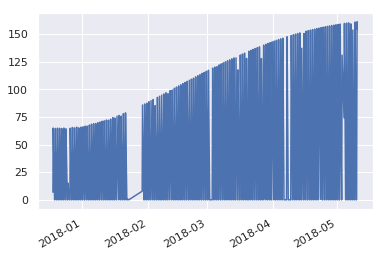

In [47]:
mc.ac.plot()